_Covid Cases by Inner London Borough Dashboard, created by Cerith Freeman in 2024  based on [health data](https://ukhsa-dashboard.data.gov.uk/) published by the [UK Health Security Agency](https://www.gov.uk/government/organisations/uk-health-security-agency) and  [population data](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough) from the [Greater London Authority](https://www.london.gov.uk), using the [DIY Disease Tracking Dashboard Kit](https://github.com/fsmeraldi/diy-covid19dash) by Fabrizio Smeraldi. Released under the [GNU GPLv3.0 or later](https://www.gnu.org/licenses/)._

# Covid Cases by Inner London Borough

This dashboard visualises [health data published by the UKHSA](https://ukhsa-dashboard.data.gov.uk/), focusing primarily on the number of registered cases of COVID-19 in the inner boroughs of London from 2020 to the present (2024). 

## Population Data

Before looking at the Covid-related data, however, I did want to contextualise my findings first. I downloaded the Greater London Authority's [population data](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough) for the inner boroughs of London to see how they compare in regard to both their population and their population density. I was interested to see if either metric correlated closely with the number of Covid cases reported in each borough.

**Note:** The UKHSA data groups the City of London together with the borough of Hackney, while the Greater London Authority's data lists them separately. For consistency, I have grouped the City's data with Hackney's so that the data can be more easily compared. Also worth noting is that the GLA's data are projections made in 2016, but they should be alright for this purpose.

When plotted onto graphs, the GLA's data shows us this:

In [96]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import time
import json
global df

In [97]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [98]:
boroughs = [
    # Note: Despite not being a borough, the UKHSA data includes the City of London with the
    # London borough of Hackney. I've called everything here a borough for ease of use.

    # Inner London Boroughs
    "Camden",
    "Greenwich",
    "Hackney and City of London",
    "Hammersmith and Fulham",
    "Islington",
    "Kensington and Chelsea",
    "Lambeth",
    "Lewisham",
    "Southwark",
    "Tower Hamlets",
    "Wandsworth",
    "Westminster",
]

In [99]:
# This block of code accesses the Covid data stored in a JSON file. The JSON file is formatted as a dictionary with each borough as the key
# and each value being a dictionary, whose keys are indexes and values are a dictionary of data each. This block removes the intermediate indexes,
# so that the format of the data is simply a dictionary with a borough as they key and a list of dictionaries as the values. This is done so
# that the wrangle_data() function can interact with the saved JSON data and the API data in exactly the same way.
with open("covid_data.json") as file:
    file = pd.read_json(file)
    jsondata = {}
    for borough in boroughs:
        borough_data = []
        for i in file[borough].keys():
            borough_data.append(file[borough][i])
        jsondata[borough] = borough_data

# This loads pre-prepared population data from a different JSON file
with open("borough_populations.json") as file:
    pop_json = pd.read_json(file)

In [100]:
# Creating dataframes to show population and population density information for each borough 2020-2024
pop_df = pd.DataFrame(index = boroughs, columns = list(range(2020,2025)))
density_df = pd.DataFrame(index = boroughs, columns = list(range(2020,2025)))

for index, row in pop_json.iterrows():
    pop_df.loc[row["Name"], row["Year"]] = row["Population"]
    density_df.loc[row["Name"], row["Year"]] = row["Population_per_square_kilometre"]

Text(0, 0.5, 'Population per square kilometre')

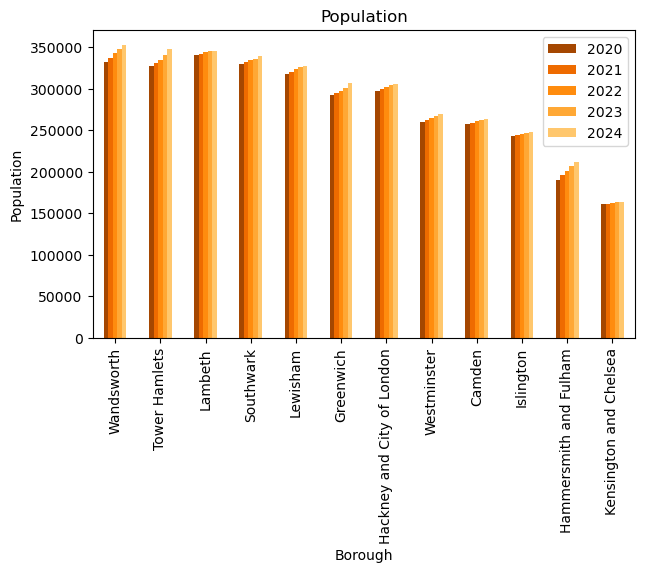

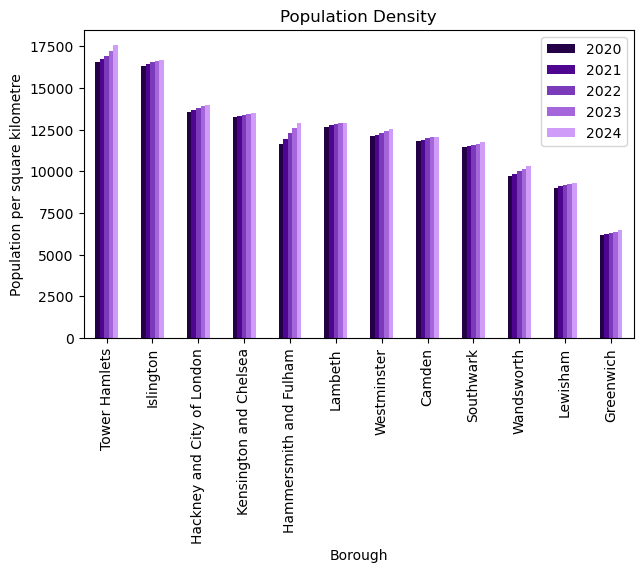

In [101]:
#Plotting graphs for the above 2 dataframes 
oranges = ["#A54701", "#EE6B00", "#FF8C0E", "#FFA835", "#FFC76D"]
purples = ["#240046", "#4E0691", "#7A3AB9", "#A466DA", "#CF9CF8"]

pop_df = pop_df.sort_values(2024, ascending=False)
pop_df.plot(kind="bar", color=oranges, figsize=(7,4)).set_title("Population")
plt.xlabel("Borough")
plt.ylabel("Population")

density_df = density_df.sort_values(2024, ascending=False)
density_df.plot(kind="bar", color=purples, figsize=(7.1,4)).set_title("Population Density")
plt.xlabel("Borough")
plt.ylabel("Population per square kilometre")

Here, we can make some observations. Namely, that Wandsworth is the most populous borough and Kensington and Chelsea the least. This interestingly doesn't align too closely with the population density graph, where Wandsworth is towards the lower end of the scale and Kensington and Chelsea higher up. Tower Hamlets is the densest borough, and Greenwich the least dense. We can have a look at the COVID-19 data below to see if either density or absolute population was a strong factor in the number of COVID-19 cases reported in each borough.

In [102]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [103]:
def wrangle_data(rawdata):
    """ Parameters: rawdata - data from json file or API call. Returns a dataframe.
    Includes the code that wrangles the data, creates the dataframe and fills it in. """    
    data = {}
    
    for borough in boroughs:
        for entry in rawdata[borough]:
            if entry["date"] not in data.keys():
                data[entry["date"]] = {borough: entry["metric_value"]}
            else:
                data[entry["date"]].update({borough: entry["metric_value"]})

    dates = list(data.keys())
    dates.sort()
    startdate = parse_date(dates[0])
    enddate = parse_date(dates[-1])
    index=pd.date_range(startdate, enddate, freq='D')
    df=pd.DataFrame(index= index, columns= boroughs)

    for date, entry in data.items():
        pd_date = parse_date(date)
        for borough in boroughs:
            value = entry.get(borough, 0.0)
            df.loc[date, borough] = value
        
    return df

df = wrangle_data(jsondata)

In [104]:
# Saving the dataframe to a pickle file:
df.to_pickle("covid_by_borough.pkl")

In [105]:
# The APIwrapper class that will be used by the access_api() function

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # builds the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [106]:
# The API access code is in this function, which is called when the "Refresh data" button is clicked.
def access_api():
    """ Accesses the UKHSA API. Return data as a like-for-like replacement for the "canned" data loaded from the JSON file. """
   
    structure={"theme": "infectious_disease", 
            "sub_theme": "respiratory",
            "topic": "COVID-19",
            "geography_type": "Upper Tier Local Authority", 
            "metric": "COVID-19_cases_casesByDay"}

    all_data = {}

    for borough in boroughs:
        structure["geography"] = borough
        api=APIwrapper(**structure)
        data=api.get_all_pages()

        all_data[borough] = data
    
    return all_data # return data read from the API

## COVID-19 Data

With the above data in mind, I went ahead and plotted the data on Covid-19 cases gathered by UKHSA.

### Graph 1: Line graph of all boroughs

First, I simply plotted all boroughs' data on a simple line graph. As you can see, it is very difficult to see all the data clearly due to the number of boroughs presented. One can see, however, that all boroughs had their respective spikes in cases at around the same times.

<Axes: >

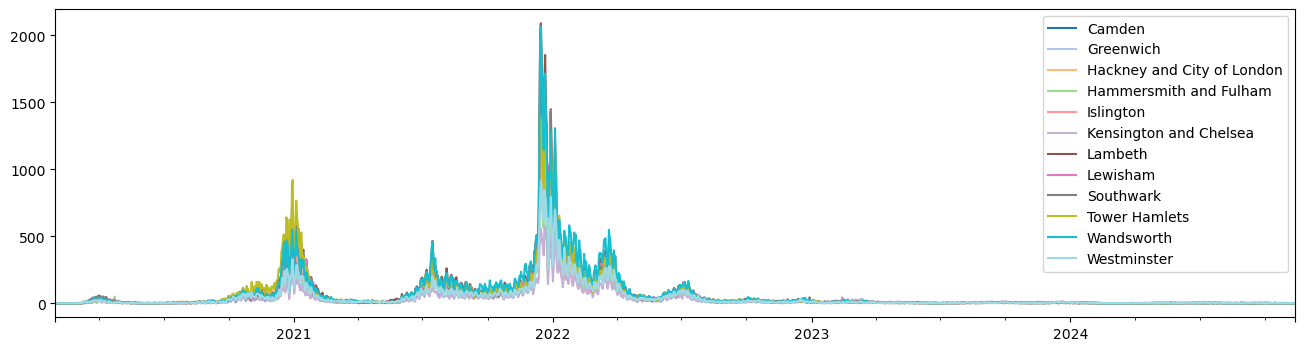

In [107]:
# Creating a line graph:
graph1 = df
graph1.plot(logy=False, figsize=(16,4), cmap='tab20')

### Graph 2: Multi-control line graph

I then decided it would be best to add controls to the graph to increase clarity. Click on a borough from the list below to see its data by itself, or hold Ctrl/Cmd + click to compare multiple boroughs with each other. Use the radio buttons to choose between a logarithmic or linear scale, and optionally view gridlines by clicking on the "Show gridlines?" checkbox.

In [108]:
# Creating controls for the graph
series=wdg.SelectMultiple(
    options = boroughs,
    value = boroughs,
    rows= len(boroughs),
    description='Borough(s):',
    disabled=False
)

scale=wdg.RadioButtons(
    options=['linear', 'log'],
    value='linear',
#   layout={'width': 'max-content'}, # Not needed
    description='Scale:',
    disabled=False
)

gridlines = wdg.Checkbox(
    value=False, 
    description="Show gridlines?",
)
    
# Putting the controls together
controls=wdg.HBox([series, wdg.VBox([scale, gridlines])])

def refresh_graph():
    """ We change the value of the widget in order to force a redraw of the graph;
    this is useful when the data have been updated. This is a bit of a gimmick; it
    needs to be customised for one of your widgets. """
    current=scale.value
    if current==scale.options[0]:
        other=scale.options[1]
    else:
        other=scale.options[0]
    scale.value=other # forces the redraw
    scale.value=current # now we can change it back

def boroughs_graph(gcols, gscale, glines):
    if gscale=='linear':
        logscale=False
    else:
        logscale=True
    ncols=len(gcols)
    if ncols>0:
        df[list(gcols)].plot(logy=logscale, figsize=(16,6), cmap='tab20')
        if glines:
            plt.grid(which='both', linestyle='--', linewidth=0.5)
        plt.xlabel("Date")
        plt.ylabel("# of cases")
        plt.show() # important - graphs won't update if this is missing 
    else:
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")

# Putting graph together
graph2=wdg.interactive_output(boroughs_graph, {'gcols': series, 'gscale': scale, 'glines': gridlines})

# Displaying the graph
display(controls, graph2)

Output()

In [109]:
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling
    # around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global df
    df=wrangle_data(apidata)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # The function needs to be adapted to your graph; you can omit this call
    # in the first instance
    refresh_graph()
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. If you are 
    # implementing error handling, you can use icons "unlink" or "times" and 
    # change the button text to "Unavailable" when the api call fails.
    apibutton.icon="check"
    apibutton.button_style="success"
    apibutton.description="Data refreshed!"
    # apibutton.disabled=True

    
apibutton=wdg.Button(
    description='Refresh data?', # you may want to change this...
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Keep calm and carry on",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='refresh'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets
display(apibutton)

# run all cells before clicking on this button

Button(button_style='info', description='Refresh data?', icon='refresh', style=ButtonStyle(), tooltip='Keep ca…

This data was initially accessed and saved in November 2024. To see the most up-to-date data from the UKSHA's API, click on the button above. Please be patient as it may take a moment!

Looking at the above data, it seems that population density doesn't account for as much as I thought in regards to the COVID-19 cases reported. Absolute population, on the other hand, does seem to be a bigger contributor, as the numbers for Wandsworth are much larger than those for Kensington and Chelsea or Hammersmith and Fulham, for example.

### Graph 3: Stacked bar chart

Lastly, I wanted to see whether any boroughs were clearly more affected by cases of COVID-19 than others based on percentage. Interestingly, this does seem to be the case somewhat (Kensington and Chelsea, for example, seems to have had fairly low numbers), but the difference is not as stark as I might have expected. It is also interesting to see how some boroughs seemed to be have a larger or smaller proportion of London's COVID cases at different times (Wandsworth looks like it had a higher percentage of cases earlier on in the pandemic than in the most recent years, for example), but again, this change does not seem to be very drastic.

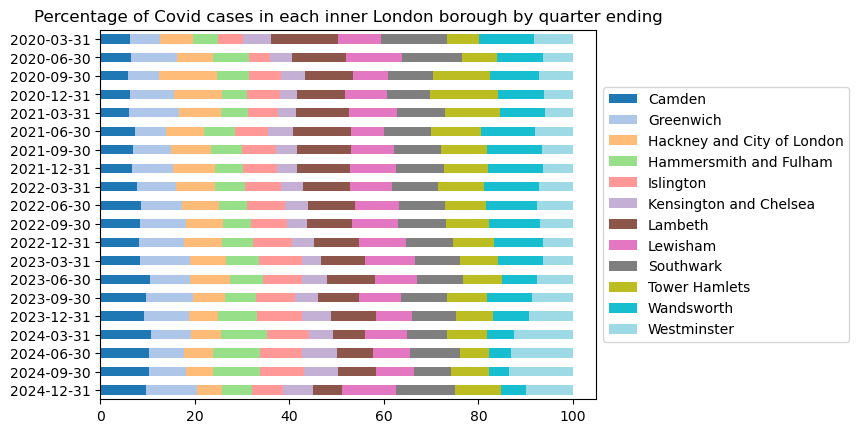

In [110]:
# Creating the third graph

# 1Q means "by quarter"; compute the average row
quarterly= df.groupby(pd.Grouper(freq='1QE')).mean() 
# since some data are missing, the sum across an average row may be less than one
totals=quarterly.sum(axis=1) # sum over the rows
# make sure it's all normalised to 100
quarterly=quarterly.div(totals, axis=0)*100 # divide the columns by the totals
# reverse the rows for the graph, so older dates will be on top
quarterly = quarterly[::-1]
# we need a colormap with more than 11 colours 
ax=quarterly.plot(kind='barh', stacked=True,cmap='tab20')
ax.legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
# format the dates nicely
ax.set_yticklabels(quarterly.index.strftime('%Y-%m-%d'))
ax.set_title('Percentage of Covid cases in each inner London borough by quarter ending');

I hope you enjoyed seeing this data visualised and that you were able to make your own findings by interacting with the graphs! Go ahead and play around with the controls to see what you can find out. Thank you for viewing my dashboard!